In [7]:
# sum up over a region, with fractions of a pixel
# wavea = blue edge; waveb = red edge
# c1 and c2 are the edges of the region of interest
# mean returns the average of the pixels rather than the sum
# check makes plots
def fracsum(wavea, waveb, flux, c1, c2, mean=False, check=False):
  
    pixwidth = waveb-wavea  
    fracused = np.zeros_like(flux)
  
    # make sure wide enough
    if (wavea[0]>=c1) or (waveb[-1]<=c2):
      return None
    
    # whole pixels
    wholeind, = np.where( (wavea>=c1) & (waveb<=c2) )
    if len(wholeind) == 0:
      print("WARNING fracsum: no whole pixels")
    fracused[wholeind] = 1.
    
    # partial pixels
    lowind, = np.where( (wavea<c1) & (waveb>c1) )
    uppind, = np.where( (wavea<c2) & (waveb>c2) )
    assert(len(lowind) <= 1)
    assert(len(uppind) <= 1)

    if (len(lowind) == 1) and (not (lowind in wholeind)):
      fracused[lowind] = (waveb[lowind]-c1)/pixwidth[lowind]
    if (len(uppind) == 1) and (not np.any(uppind in wholeind)):
      fracused[uppind] = (c2-wavea[uppind])/pixwidth[uppind]

    if check:
      plt.scatter(wavea, flux)
      plt.scatter(waveb, flux)
      plt.plot([c1,c1],[0,10])
      plt.plot([c2,c2],[0,10])
      print(np.arange(0,len(flux)))
      print(fracused)
      print(flux)
    
    integral = np.sum(flux*fracused*pixwidth)
    if mean:
      return integral/np.sum(fracused*pixwidth)
    else:
      return integral

In [8]:
# assume pixel edges are half-way between the central locations
def simple_fracsum(wave, flux, c1, c2, mean=False):
  
    diff = np.array(wave.flat[1:] - wave.flat[:-1])
    pixwidth = np.concatenate(([diff[0]], (diff[1:]+diff[:-1])/2., [diff[-1]]))

    wavea = wave-pixwidth/2.
    waveb = wave+pixwidth/2.
   
    return fracsum(wavea, waveb, flux, c1, c2, mean=mean)

In [22]:
# EW of arbitrary line     
def measure_eqw(wave, flux, line_start, line_end, blue_cont_start, blue_cont_end, 
               red_cont_start, red_cont_end, trapsum=False):
    
    # feature region
    feature = [line_start,line_end]
    
    m1 = simple_fracsum(wave, flux, blue_cont_start, blue_cont_end, mean=True)
    m2 = simple_fracsum(wave, flux, red_cont_start, red_cont_end, mean=True)
    pseudo = (m1+m2)/2.

    ew = simple_fracsum(wave, 1.-flux/pseudo, feature[0], feature[1])
    return ew

In [5]:
#ensure that print and division functions work correctly under python 2.X
from __future__ import print_function, division 

#import numpy, scipy, math and astropy libraries
import numpy as np
import scipy as sp
import math
import astropy

#import Elisabeth Newton's EqW measurement routines (from https://github.com/ernewton/ernlib/blob/master/eqwidth.py) 
#actually, just copy cells above for expediency.  from eqwidth import fracsum, simple_fracsum

#import the interpolate command
from scipy.interpolate import interp1d

#import matplotlib so that we can make plots; import common subroutines and give them compact names
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.colorbar as cb

#ensure that plots show up in our notebook (comment this out if converting to a script)
%matplotlib inline

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

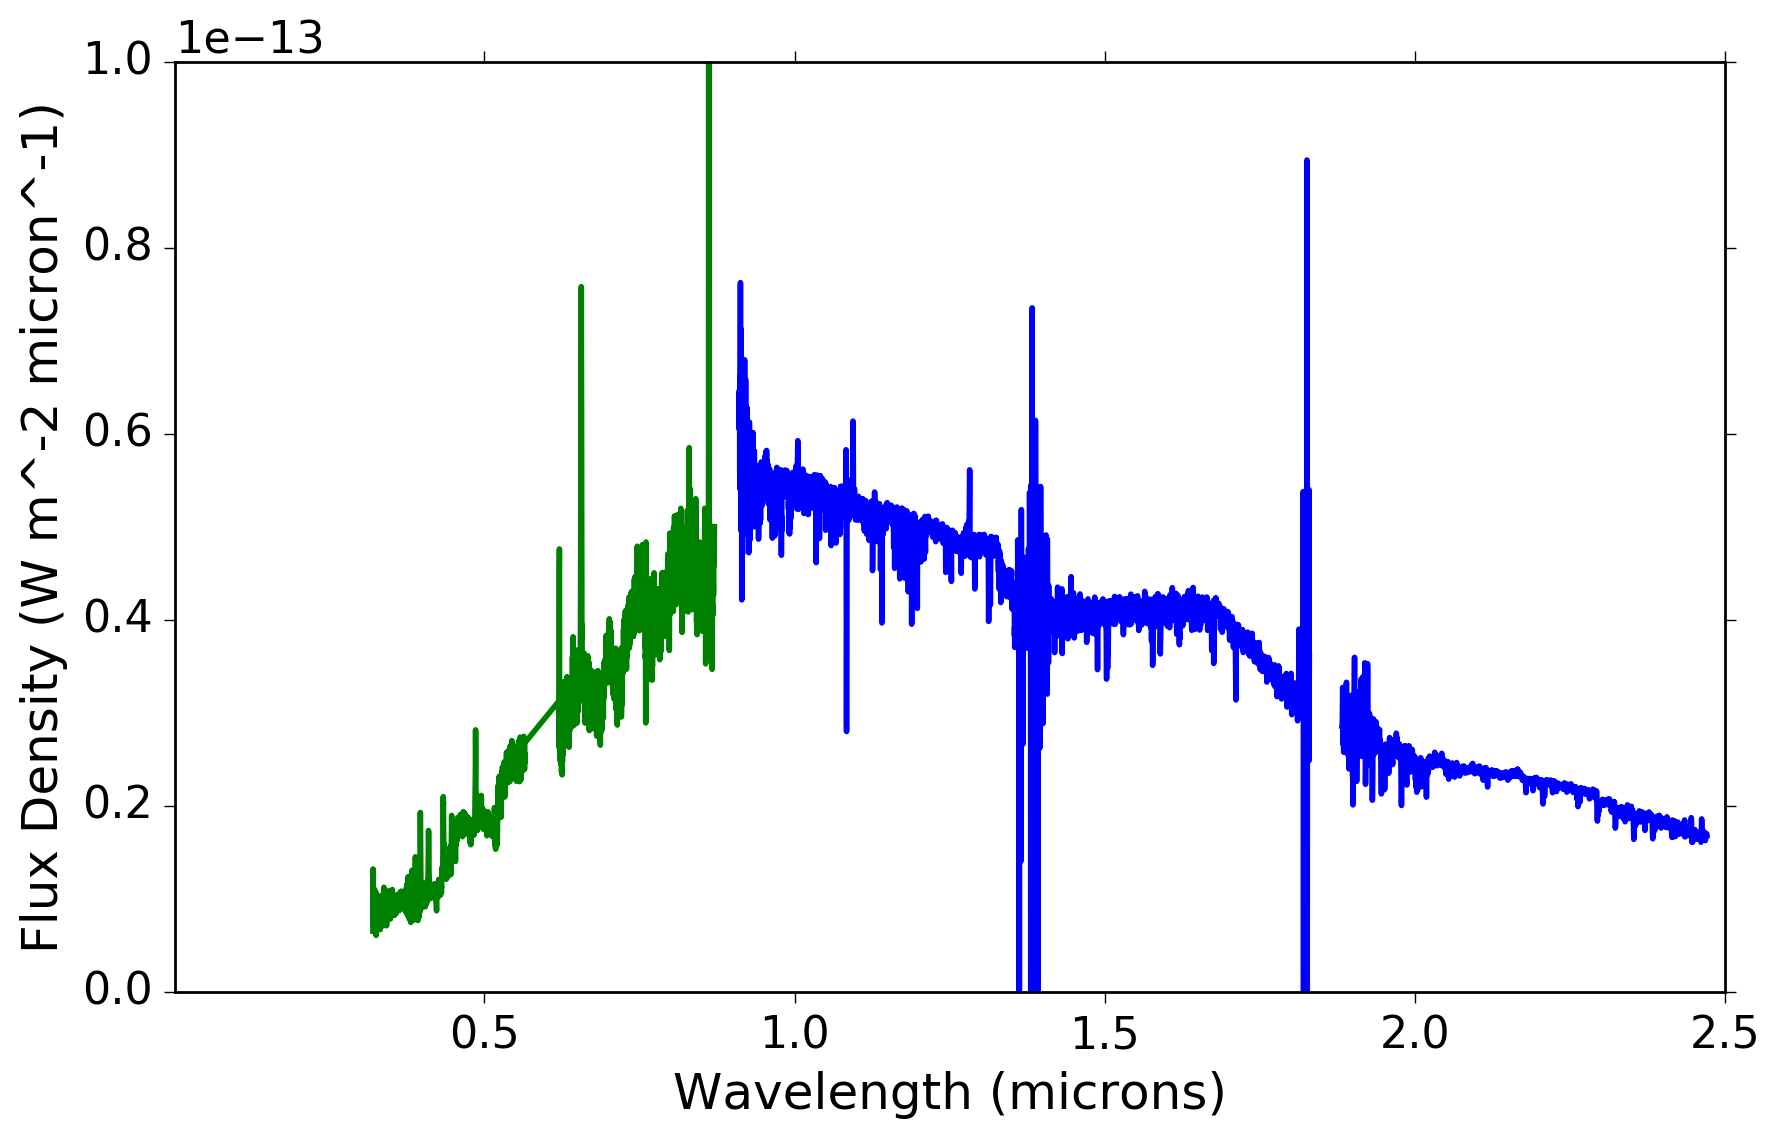

In [18]:
#Read in AA Tau's 2008 spectrum, starting with the IR channel
IRSpec_2008 = np.genfromtxt('spectra/AATau_IR2008.spec', usecols=range(2), filling_values = -99.)

#Store the individual flux and wavelength columns as separate arrays for ease of use
IRSpec_2008.shape
IRSpec_2008_wavelength = IRSpec_2008[:,0]
IRSpec_2008_flux = IRSpec_2008[:,1]

#Now read in AA Tau's 2008 optical spectrum
OptSpec_2008 = np.genfromtxt('spectra/AATau_opt2008.spec', usecols=range(2), filling_values = -99.)

#Store the individual flux and wavelength columns as separate arrays for ease of use
OptSpec_2008.shape
OptSpec_2008_wavelength = OptSpec_2008[:,0]
OptSpec_2008_flux = OptSpec_2008[:,1]

plt.plot(IRSpec_2008_wavelength, IRSpec_2008_flux, linewidth = 2)
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux, linewidth = 2)

#And now compute and overlay the blackbody curve
#scaled_solarlike_blackbody = planckMicron(wavelength_microns[:],5770)/(1.5E10)

#plt.plot(wavelength_microns[:],scaled_solarlike_blackbody,linewidth = 4, color = 'y')
plt.axis([1E-3,2.5,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

-0.00203733272388


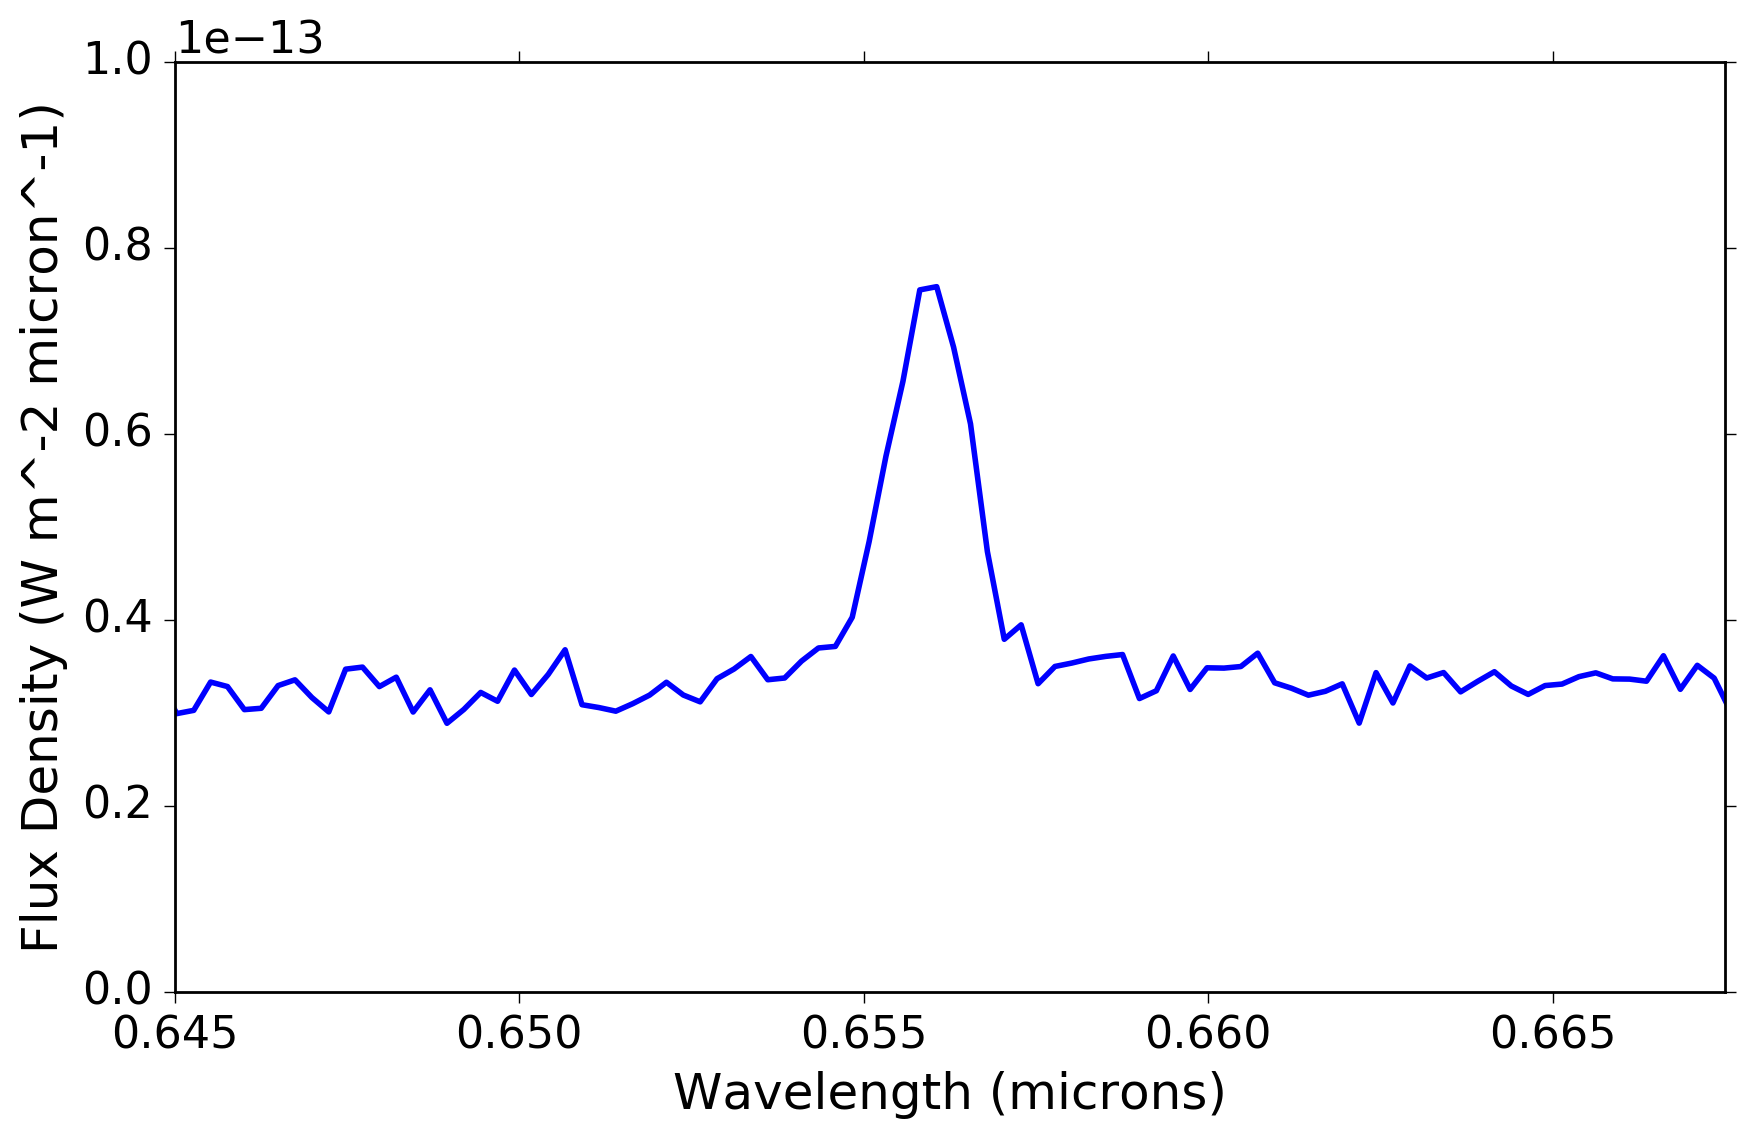

In [28]:
#Now zoom in on Halpha and compute the EqW.
plt.plot(OptSpec_2008_wavelength, OptSpec_2008_flux, linewidth = 2)
plt.axis([0.645,0.6675,0,1E-13])
xlabel = plt.xlabel('Wavelength (microns)') 
ylabel = plt.ylabel('Flux Density (W m^-2 micron^-1)')  #ARE THESE ACTUALLY THE RIGHT UNITS????

HaEqW_2008 = measure_eqw(OptSpec_2008_wavelength, OptSpec_2008_flux, 0.654, 0.6575, 0.645, 0.65, 
               0.66, 0.665, trapsum=False)
print(HaEqW_2008)